# Graph Building Notebook

Author: Christian Spiteri Gauci

## Method

* Graph data as an output from the post_feature_engineering is loaded
* Nodes - Every subreddit and every word2 - word2 being noun/pronoun, subreddit being the mental health diseases
* Going through every entry, if node already exist - use it, if not create a new one
* comparing word2 (noun) with subreddit entries - if the same, the subreddit node is to be used and points to itself, or to another subreddit node
* Word 1 (the verb) is a node of type 'Verb'
* Word 2 and Word 1 are connected together with relationships of type dobj or nsubj
* The direction of the relationship is determined by the semantics of the sentence - dobj or nsubj
* Mental health disease is connected to each verb via a relationship of type HAS_WORD 





In [3]:
import pandas as pd
import numpy as np
from py2neo import Graph, Node, Relationship
import ast
import os
from dotenv import load_dotenv
from os import getenv
from concurrent.futures import ThreadPoolExecutor
import gc
import concurrent.futures
from tqdm import tqdm
import threading
import networkx as nx
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

In [4]:
load_dotenv()

client_id = os.getenv('N4J_USER')
client_secret = os.getenv('N4J_PW')

graph = Graph(uri="bolt://localhost:7687", auth=(client_id, client_secret))

In [5]:
# df = pd.read_csv("./data/GraphData.csv")
# # sample_percentage = 0.1
# num_rows = 10000

# # sampled_df = df.sample(frac=sample_percentage, random_state=42) 
# test_df = df.sample(n=num_rows, random_state=42)

# test_df.to_csv("./data/GraphData_test.csv", index=False)

sampled_df = pd.read_csv("./data/GraphData_sampled_LOCKED.csv")

From Spacy: https://github.com/clir/clearnlp-guidelines/blob/master/md/specifications/dependency_labels.md

nsubj - nominal subject (verb (action) performed by the NS)
dobj - direct object  (verb (action) performed on the DO)

This is used to determine the direction of the relationship.

In [8]:
import math  # Import the math module to check for NaN

graph.delete_all()
existing_nodes = {}
tx = graph.begin()

for row in tqdm(sampled_df.itertuples(), total=len(sampled_df), desc="Processing Rows", position=0):
    # Check if the Subreddit node already exists
    existing_subreddit = existing_nodes.get(row.Subreddit.lower())

    if existing_subreddit:
        subreddit_node = existing_subreddit
    else:
        subreddit_node = Node("Mental_Health_Disorder", name=row.Subreddit.lower()) 
        tx.create(subreddit_node)
        existing_nodes[row.Subreddit.lower()] = subreddit_node

    
    # Check if the Word node already exists
    word2_value = row.Word2
    if isinstance(word2_value, str):
        word2_lowercase = word2_value.lower()
    elif isinstance(word2_value, float) and math.isnan(word2_value):
        # Handle NaN values in 'Word2'
        continue  # Skip this iteration if 'Word2' is NaN
    else:
        # Handle other non-string cases
        word2_lowercase = str(word2_value).lower()

    existing_word = existing_nodes.get(word2_lowercase)   

    if word2_lowercase == row.Subreddit.lower():
        word2_node = subreddit_node  # Use the Subreddit node for Word2
    elif existing_word:
        word2_node = existing_word
    else:
        word2_node = Node("Word", name=word2_lowercase)
        tx.create(word2_node)
        existing_nodes[word2_lowercase] = word2_node

    mh_labels_dict = ast.literal_eval(row.MHlabels)

    # Determine the relationship direction based on 'Dependency'
    if row.Dependency == 'dobj':
        # If 'Dependency' is 'dobj', create relationship from 'Subreddit' to 'Word2'
        relationship = Relationship(subreddit_node, row.Word1, word2_node, **mh_labels_dict)
    elif row.Dependency == 'nsubj':
        # If 'Dependency' is 'nsubj', create relationship from 'Word2' to 'Subreddit'
        relationship = Relationship(word2_node, row.Word1, subreddit_node, **mh_labels_dict)
    else:
        continue

    tx.create(relationship)

print()
graph.commit(tx)


Processing Rows:   0%|          | 0/100000 [00:00<?, ?it/s]

Processing Rows: 100%|██████████| 100000/100000 [4:57:26<00:00,  5.60it/s] 


In the code above, we have Word2 (pronoun) connected directly to Subreddit(Class) via Word1 (Verb).
However this means that we are losing interconnectivity infomration.

For example:
Entry 1:  Steal(Word1), nsubj, Man(Word2)
Entry 2: Steal(Word1), dobj, Purse(Word2)

From the graph above, i can never link the two lines mentioned above. since there won't be a connection.

Below the graph is fixed to have Word2 connected to Word1 via a directional edge (relationship) and then this is connected to the Class. This way the graph holds a lot more information and more meaningful analysis can be performed

In [9]:
import ast

graph.delete_all()
existing_nodes = {}
tx = graph.begin()

for row in tqdm(sampled_df.itertuples(), total=len(sampled_df), desc="Processing Rows", position=0):
    # Check if the Subreddit node already exists
    existing_subreddit = existing_nodes.get(row.Subreddit.lower())

    if existing_subreddit:
        subreddit_node = existing_subreddit
    else:
        subreddit_node = Node("Mental_Health_Disorder", name=row.Subreddit.lower()) 
        tx.create(subreddit_node)
        existing_nodes[row.Subreddit.lower()] = subreddit_node

    # Check if the Word1 node already exists
    word1_lowercase = row.Word1.lower()
    existing_word1 = existing_nodes.get(word1_lowercase)

    if existing_word1:
        word1_node = existing_word1
    else:
        word1_node = Node("Verb", name=word1_lowercase)
        tx.create(word1_node)
        existing_nodes[word1_lowercase] = word1_node

        # Connect Word1 to the Subreddit class
        relationship_subreddit_to_word1 = Relationship(subreddit_node, "HAS_WORD", word1_node)
        tx.create(relationship_subreddit_to_word1)


    # Check if the Word2 node already exists
    if isinstance(row.Word2, str):
        word2_lowercase = row.Word2.lower()
        existing_word2 = existing_nodes.get(word2_lowercase)

        if word2_lowercase == row.Subreddit.lower():
            word2_node = subreddit_node  # Use the Subreddit node for Word2
        elif existing_word2:
            word2_node = existing_word2
        else:
            word2_node = Node("Word", name=word2_lowercase)
            tx.create(word2_node)
            existing_nodes[word2_lowercase] = word2_node

        mh_labels_dict = ast.literal_eval(row.MHlabels)

        # Determine the relationship direction based on 'Dependency'
        if row.Dependency == 'dobj':
            # If 'Dependency' is 'dobj', create relationship from Word1 to Word2
            relationship_word1_to_word2 = Relationship(word1_node, row.Dependency, word2_node, **mh_labels_dict)
            tx.create(relationship_word1_to_word2)
        elif row.Dependency == 'nsubj':
            # If 'Dependency' is 'nsubj', create relationship from Word2 to Word1
            relationship_word2_to_word1 = Relationship(word2_node, row.Dependency, word1_node, **mh_labels_dict)
            tx.create(relationship_word2_to_word1)
        else:
            continue

print()
graph.commit(tx)


Processing Rows: 100%|██████████| 100000/100000 [6:34:21<00:00,  4.23it/s] 


Importing the word embeddings and adding them to the existing nodes in the graph

In [10]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
driver = GraphDatabase.driver(uri, auth=(client_id, client_secret))

word_embeddings = KeyedVectors.load('./data/word2vec_embeddings.bin')


# Iterate through nodes and update attributes
with driver.session() as session:
    for node in graph.nodes:
        if node in word_embeddings.wv:
            embedding = word_embeddings.wv[node].tolist()
            session.run(
                f"MATCH (n) WHERE id(n) = {node} SET n.embedding = $embedding",
                embedding=embedding,
            )

# Close the Neo4j driver
driver.close()

In [11]:
# Query to return all nodes in the graph
# query = "MATCH (n) return n"
# graph.run(query).data()

### Identifying Key Nodes and visualising them

* Degree Centrality
* Betweneess Centrality
* EigenVector Centality

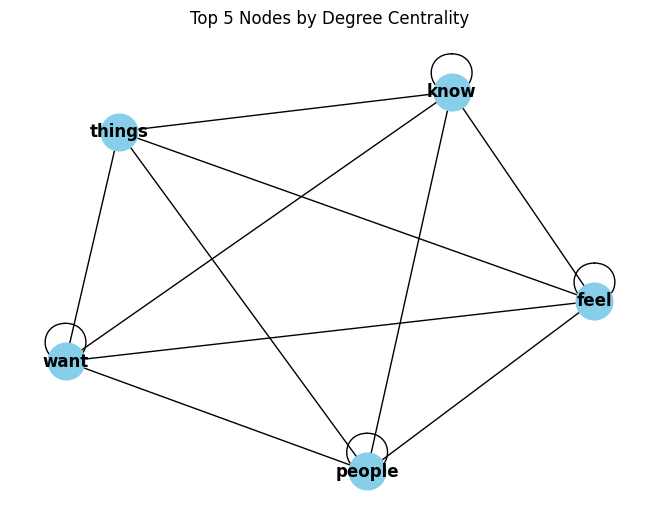

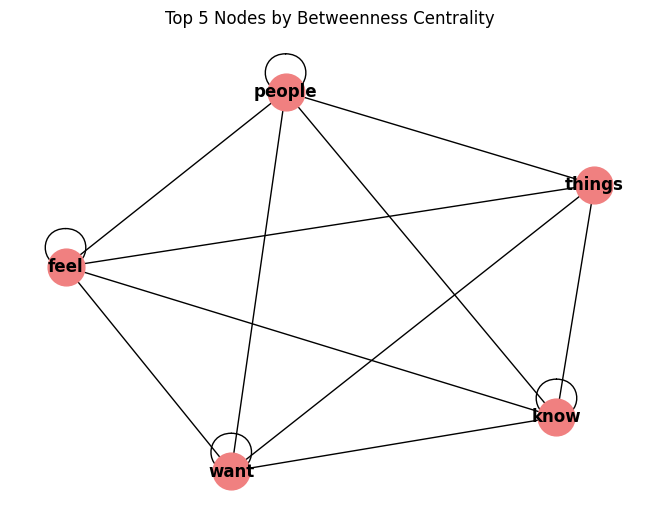

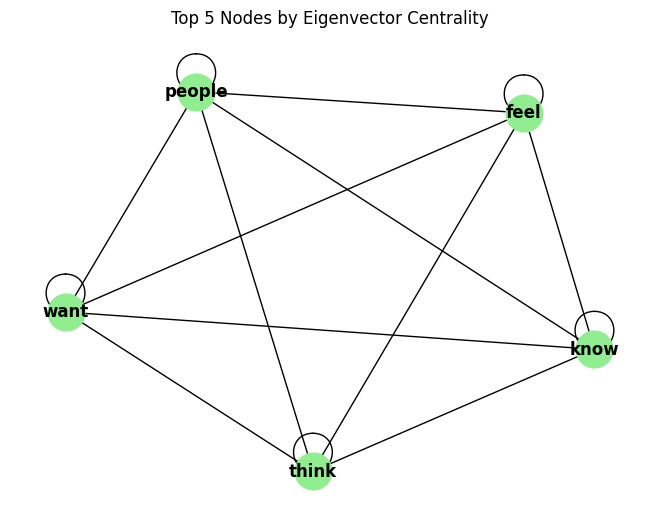

In [12]:
# Cypher query to get nodes and their labels, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)
WHERE NOT n:Mental_Health_Disorder
RETURN id(n) as id, n.name as label
"""

result = graph.run(query)
node_labels = {record['id']: record['label'] for record in result}

# Cypher query to get relationships and their nodes, excluding nodes of type "Mental_Health_Disorder"
query = """
MATCH (n)-[r]->(m)
WHERE NOT n:Mental_Health_Disorder AND NOT m:Mental_Health_Disorder
RETURN id(n) as source, id(m) as target
"""

result = graph.run(query)
edges = [(record['source'], record['target']) for record in result]

G = nx.Graph(edges)

# Calculate Degree Centrality
degree_centrality = nx.degree_centrality(G)

top_degree_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:5]

subgraph_degree = G.subgraph(top_degree_nodes)
labels_degree = {node: node_labels[node] for node in subgraph_degree.nodes}
pos_degree = nx.spring_layout(subgraph_degree)
nx.draw(subgraph_degree, pos_degree, with_labels=True, labels=labels_degree, font_weight='bold', node_size=700, node_color='skyblue')
plt.title('Top 5 Nodes by Degree Centrality')
plt.show()

# Calculate Betweenness Centrality
betweenness_centrality = nx.betweenness_centrality(G)

top_betweenness_nodes = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:5]

subgraph_betweenness = G.subgraph(top_betweenness_nodes)
labels_betweenness = {node: node_labels[node] for node in subgraph_betweenness.nodes}
pos_betweenness = nx.spring_layout(subgraph_betweenness)
nx.draw(subgraph_betweenness, pos_betweenness, with_labels=True, labels=labels_betweenness, font_weight='bold', node_size=700, node_color='lightcoral')
plt.title('Top 5 Nodes by Betweenness Centrality')
plt.show()

# Calculate Eigenvector Centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

top_eigenvector_nodes = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:5]

subgraph_eigenvector = G.subgraph(top_eigenvector_nodes)
labels_eigenvector = {node: node_labels[node] for node in subgraph_eigenvector.nodes}
pos_eigenvector = nx.spring_layout(subgraph_eigenvector)
nx.draw(subgraph_eigenvector, pos_eigenvector, with_labels=True, labels=labels_eigenvector, font_weight='bold', node_size=700, node_color='lightgreen')
plt.title('Top 5 Nodes by Eigenvector Centrality')
plt.show()

### Community Detection - Using Louvain Algorithm


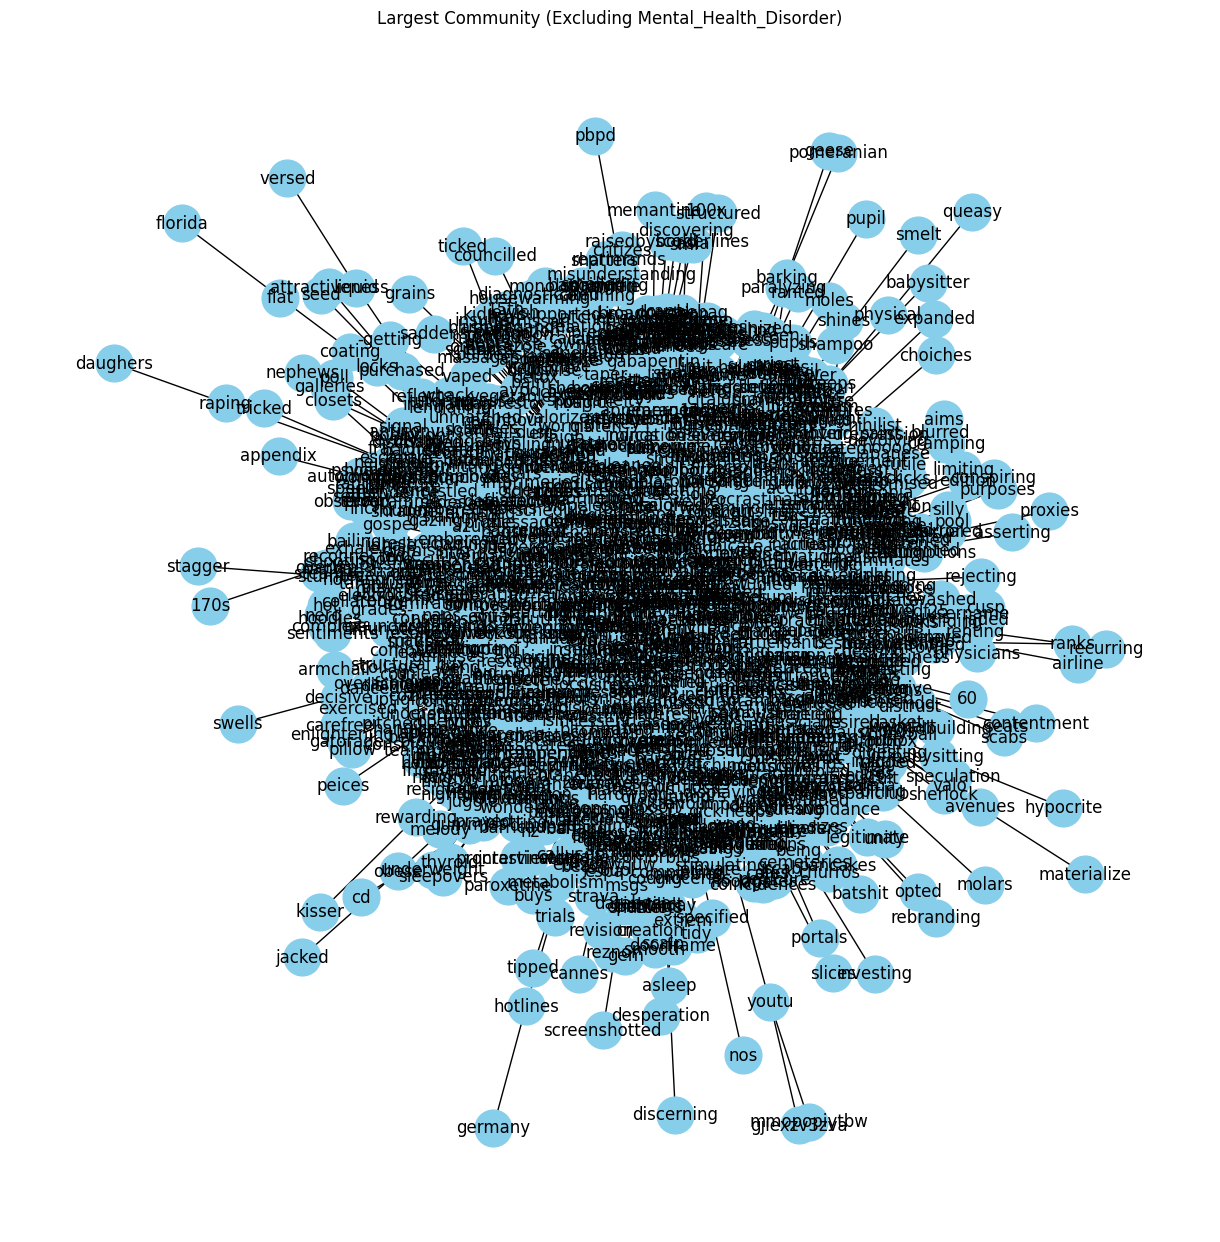

In [13]:
import community

query_nodes = """
MATCH (n)
WHERE NOT n:Mental_Health_Disorder
RETURN id(n) as id, n.name as label
"""

query_edges = """
MATCH (n)-[r]->(m)
WHERE NOT n:Mental_Health_Disorder AND NOT m:Mental_Health_Disorder
RETURN id(n) as source, id(m) as target
"""

result_nodes = graph.run(query_nodes)
result_edges = graph.run(query_edges)

node_labels = {record['id']: record['label'] for record in result_nodes}
edges = [(record['source'], record['target']) for record in result_edges]

G = nx.Graph(edges)

# Perform Louvain community detection
partition = community.best_partition(G)


communities = {}
for node, comm_id in partition.items():
    if comm_id not in communities:
        communities[comm_id] = [node]
    else:
        communities[comm_id].append(node)

# Find the largest community
largest_comm = max(communities, key=lambda k: len(communities[k]))

# Create a subgraph with nodes from the largest community
largest_comm_nodes = communities[largest_comm]
G_largest_comm = G.subgraph(largest_comm_nodes)


plt.figure(figsize=(12, 12))
pos_largest_comm = nx.spring_layout(G_largest_comm)


missing_nodes = [node for node in G_largest_comm.nodes if node not in pos_largest_comm]
if missing_nodes:
    print(f"Error: Missing positions for nodes {missing_nodes}")
else:

    nx.draw(G_largest_comm, pos=pos_largest_comm, node_color='skyblue', with_labels=False, node_size=700)
    labels = {node: node_labels[node] for node in G_largest_comm.nodes}
    nx.draw_networkx_labels(G_largest_comm, pos=pos_largest_comm, labels=labels)

    plt.title('Largest Community (Excluding Mental_Health_Disorder)')
    plt.show()